# Layer Heuristic: Linear Probing on Residual Stream

This notebook investigates which layers contain the most relevant information for distinguishing between chosen and rejected responses.
We train linear probes (Logistic Regression) on the residual stream activations (last token) of layers 6, 12, 18, and 24.

**Experiment Setup:**
*   **Model:** Gemma 2 2B IT
*   **Dataset:** UltraFeedback (1000 pairs)
*   **Layers:** 6, 12, 18, 24
*   **Task:** Binary Classification (Chosen vs. Rejected)
*   **Split:** 80% Train, 20% Validation


In [1]:
import torch
from transformer_lens import HookedTransformer
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import numpy as np
import gc

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "gemma-2-2b-it"
LAYERS = [6, 12, 18, 24]
NUM_SAMPLES = 1000
BATCH_SIZE = 8

print(f"Device: {DEVICE}")


Device: cuda


In [2]:
# Load Model
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    device=DEVICE,
    dtype="bfloat16"
)

# Chat Template
chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] | trim + '\n\n' %}{% set messages = messages[1:] %}{% else %}{% set system_message = '' %}{% endif %}{% for message in messages %}{% if loop.index0 == 0 %}{% set content = system_message + message['content'] %}{% else %}{% set content = message['content'] %}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + content | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"
model.tokenizer.chat_template = chat_template


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b-it into HookedTransformer


In [3]:
# Load Dataset
dataset_name = "princeton-nlp/llama3-ultrafeedback-armorm"
dataset = load_dataset(dataset_name, split="train")

# Select subset
dataset = dataset.shuffle(seed=42).select(range(NUM_SAMPLES))
print(f"Dataset size: {len(dataset)}")

def process_example(example, tokenizer):
    chosen_msgs = example['chosen']
    rejected_msgs = example['rejected']
    
    prompt_msgs = chosen_msgs[:-1]
    chosen_response = chosen_msgs[-1]['content']
    rejected_response = rejected_msgs[-1]['content']
    
    prompt_text = tokenizer.apply_chat_template(prompt_msgs, tokenize=False, add_generation_prompt=True)
    
    chosen_text = prompt_text + chosen_response + "<end_of_turn>"
    rejected_text = prompt_text + rejected_response + "<end_of_turn>"
    
    return prompt_text, chosen_text, rejected_text

Dataset size: 1000


In [4]:
# Extract Activations
def extract_activations(model, dataset, layers, batch_size=8):
    hook_names = [f"blocks.{layer}.hook_resid_post" for layer in layers]
    
    # Storage for activations: {layer: [activations]}
    layer_activations = {layer: [] for layer in layers}
    
    # Prepare data list
    all_texts = []
    all_labels = []
    
    print("Processing dataset...")
    
    for i in tqdm(range(len(dataset)), desc="Processing"):
        p_text, c_text, r_text = process_example(dataset[i], model.tokenizer)
        
        # Truncate if necessary
        # We want to ensure prompt <= 1800 and total <= 2048
        
        # Encode
        p_tokens = model.tokenizer.encode(p_text, add_special_tokens=False)
        c_tokens = model.tokenizer.encode(c_text, add_special_tokens=False)
        r_tokens = model.tokenizer.encode(r_text, add_special_tokens=False)
        
        # Truncate prompt
        if len(p_tokens) > 1800:
            p_tokens = p_tokens[:1800]
            
        # Re-construct prompt text (optional, but safer for consistency if we re-tokenize later)
        # Actually, we can just work with tokens, but model.to_tokens expects text or list of tokens.
        # Let's keep working with text to be consistent with previous logic, but we need to be careful about re-tokenization.
        # Or we can just truncate the tokens and decode back? Decoding might change things slightly.
        # Let's just truncate the tokens and use them directly if possible.
        # model.to_tokens can take list of list of ints.
        
        # Truncate responses
        # We need p_tokens + response_tokens <= 2048
        # So response_tokens <= 2048 - len(p_tokens)
        
        max_response_len = 2048 - len(p_tokens)
        
        # Chosen
        # c_text includes prompt. We need to extract response part or just truncate the whole thing.
        # Wait, c_text = prompt + response + <end_of_turn>
        # So c_tokens should start with p_tokens (mostly).
        # Let's just truncate c_tokens and r_tokens to 2048.
        
        if len(c_tokens) > 2048:
            c_tokens = c_tokens[:2048]
        
        if len(r_tokens) > 2048:
            r_tokens = r_tokens[:2048]
            
        # Decode back to text to ensure consistent handling with model.to_tokens later
        # Or better, just pass tokens to model.to_tokens?
        # model.to_tokens handles list of strings or list of ints.
        # But we need to be careful about BOS.
        # process_example added BOS via template?
        # "chat_template = {{ bos_token }}..." -> Yes.
        # So p_tokens, c_tokens, r_tokens already have BOS if we used encode(text).
        # Wait, I used add_special_tokens=False in the loop above.
        # If text has BOS (from template), tokenizer.encode(text, add_special_tokens=False) will include it as a token.
        
        # So we can just use the truncated tokens.
        
        all_texts.append(c_tokens)
        all_labels.append(1)
        all_texts.append(r_tokens)
        all_labels.append(0)
        
    # Process in batches
    for i in tqdm(range(0, len(all_texts), batch_size), desc="Extracting activations"):
        batch_tokens_list = all_texts[i:i+batch_size]
        
        # Pad manually or use model.to_tokens
        # model.to_tokens handles padding if given a list of lists of ints?
        # It usually expects strings. If given tokens, it might just convert to tensor.
        # Let's check if we need to pad.
        # Yes, we need to pad to the longest in the batch.
        
        max_len = max(len(t) for t in batch_tokens_list)
        pad_token_id = model.tokenizer.pad_token_id
        if pad_token_id is None:
            pad_token_id = model.tokenizer.eos_token_id
            
        padded_tokens = []
        for t in batch_tokens_list:
            # Right padding
            pad_len = max_len - len(t)
            padded_tokens.append(t + [pad_token_id] * pad_len)
            
        tokens_tensor = torch.tensor(padded_tokens, dtype=torch.long, device=DEVICE)
        
        with torch.no_grad():
            _, cache = model.run_with_cache(
                tokens_tensor,
                names_filter=hook_names,
                return_type=None
            )
            
            for layer in layers:
                hook_name = f"blocks.{layer}.hook_resid_post"
                
                # Find last non-pad token
                last_token_indices = (tokens_tensor != pad_token_id).sum(dim=1) - 1
                
                acts = cache[hook_name] # [batch, seq_len, d_model]
                
                # Gather last tokens
                batch_acts = acts[torch.arange(acts.shape[0]), last_token_indices, :]
                
                # Move to CPU immediately and convert to numpy
                batch_acts_cpu = batch_acts.cpu().float().numpy()
                layer_activations[layer].append(batch_acts_cpu)
                
        # Clear cache and force garbage collection to free VRAM
        del cache
        del tokens_tensor
        torch.cuda.empty_cache()
        gc.collect()
        
    # Concatenate
    for layer in layers:
        layer_activations[layer] = np.concatenate(layer_activations[layer], axis=0)
        
    return layer_activations, np.array(all_labels)

print("Extracting activations...")
activations, labels = extract_activations(model, dataset, LAYERS, BATCH_SIZE)
print("Extraction complete.")

Extracting activations...
Processing dataset...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Extracting activations:   0%|          | 0/250 [00:00<?, ?it/s]

Extraction complete.


/home/jazhyc/projects/FSRL/feature-steering-RL/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 6 Validation Accuracy: 0.5400


/home/jazhyc/projects/FSRL/feature-steering-RL/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 12 Validation Accuracy: 0.5475


/home/jazhyc/projects/FSRL/feature-steering-RL/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 18 Validation Accuracy: 0.5300


/home/jazhyc/projects/FSRL/feature-steering-RL/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 24 Validation Accuracy: 0.4950


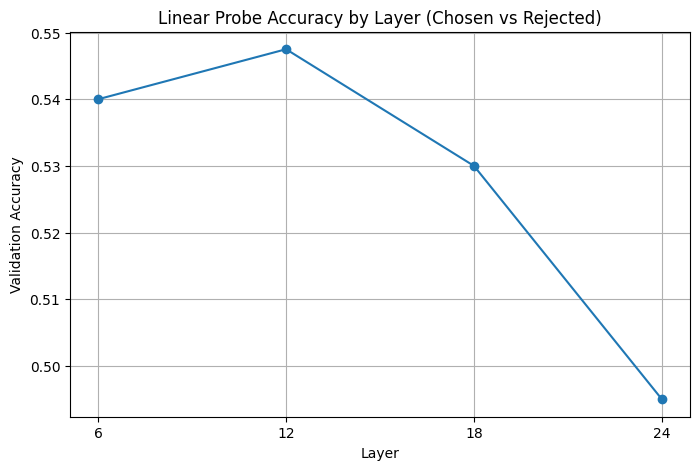

In [5]:
# Train Probes and Evaluate
results = {}

for layer in LAYERS:
    X = activations[layer]
    y = labels
    
    # Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    results[layer] = acc
    print(f"Layer {layer} Validation Accuracy: {acc:.4f}")

# Plot
import matplotlib.pyplot as plt

layers_list = sorted(results.keys())
accs = [results[l] for l in layers_list]

plt.figure(figsize=(8, 5))
plt.plot(layers_list, accs, marker='o')
plt.xlabel("Layer")
plt.ylabel("Validation Accuracy")
plt.title("Linear Probe Accuracy by Layer (Chosen vs Rejected)")
plt.grid(True)
plt.xticks(layers_list)
plt.show()
